# Project: Robotic Arm - Kinematics Pick & Place

### Project video

[![Project video](video/robot_arm_thumbnail.png)](https://www.youtube.com/watch?v=YQ9G8xxhT04)

### Project overview

In this project, a Robotic Arm having 6 degrees of freedom (DOF) has been simulated and programmed using ROS (Robot Operating System) to pick up objects present on a shelf and place them in a bucket, making use of Forward & Inverse Kinematics (Denavit-Hartenberg method).

**Project tools:**
 - **ROS (Robot Operating System)** : Robotics middleware (i.e. collection of software frameworks for robot software development)
 - **Gazebo** : A physics based 3D simulator
 - **RViz** : A 3D visualizer for sensor data analysis, and robot state visualization
 - **Moveit!** : A ROS based software framework for motion planning, kinematics and robot control

This project was submitted as part of the Udacity Robotics Nanodegree programme.

### Kinematic Analysis

The Robot Arm that is simulated is the Kuka KR 210. 

I've drawn the following diagram to illustrate the different joints, links and axes corresponding to the **Denavit-Hartenberg** method of describing manipulator kinematics as per **Craig, JJ. (2005) convention** :

![DH Diagram](images/dh_diagram.jpg)

**Legend of the above figure:**
 - Xn,Yn,Zn denotes the axes of each joint's frame of reference
 - On represents the origin of each frame
 - The triangle represents the origin of the join as given in the KR210 URDF specification (kr210.urdf.xacro)
 - The circled nos. represents the serial number of the joint
 - The wrist center is located at center of joint 5 (i.e. at O5).

#### DH Parameter Table

Links | alpha(i-1) | a(i-1) | d(i-1) | theta(i)
--- | --- | --- | --- | ---
0->1 | 0 | 0 | d1 = (0.33+0.42) = 0.75 | q1
1->2 | - pi/2 | a1 = 0.35 | 0 | -pi/2 + q2
2->3 | 0 | a2 = 1.25 | 0 | q3
3->4 |  -pi/2 | a3 = -0.054 | d4 = (0.96+0.54) = 1.5 | q4
4->5 | pi/2 | 0 | 0 | q5
5->6 | -pi/2 | 0 | 0 | q6
6->G (EE) | 0 | 0 | dG = (0.193+0.11) = 0.303 | 0

**Note** : For theta2, there is a constant offset of -90 degrees as can be seen from the initial state of joints.

### Forward Kinematics

**Individual Transformation Matrices**

Using the DH method, each transformation matrix between adjacent links is given by : 

![Individual Transformation Matrix](images/dh_individual_transform.png)

Substituting the values from each row of the DH Parameter table into the above matrix, we get : 

(The following matrices were generated using Python's sympy)

**T0_1** :
```
⎡cos(q₁)  -sin(q₁)  0   0  ⎤
⎢                          ⎥
⎢sin(q₁)  cos(q₁)   0   0  ⎥
⎢                          ⎥
⎢   0        0      1  0.75⎥
⎢                          ⎥
⎣   0        0      0   1  ⎦
```

**T1_2** :
```
⎡sin(q₂)  cos(q₂)   0  0.35⎤
⎢                          ⎥
⎢   0        0      1   0  ⎥
⎢                          ⎥
⎢cos(q₂)  -sin(q₂)  0   0  ⎥
⎢                          ⎥
⎣   0        0      0   1  ⎦
```

**T2_3** :
```
⎡cos(q₃)  -sin(q₃)  0  1.25⎤
⎢                          ⎥
⎢sin(q₃)  cos(q₃)   0   0  ⎥
⎢                          ⎥
⎢   0        0      1   0  ⎥
⎢                          ⎥
⎣   0        0      0   1  ⎦
```

**T3_4** :
```
⎡cos(q₄)   -sin(q₄)  0  -0.054⎤
⎢                             ⎥
⎢   0         0      1   1.5  ⎥
⎢                             ⎥
⎢-sin(q₄)  -cos(q₄)  0    0   ⎥
⎢                             ⎥
⎣   0         0      0    1   ⎦
```

**T4_5** :
```
⎡cos(q₅)  -sin(q₅)  0   0⎤
⎢                        ⎥
⎢   0        0      -1  0⎥
⎢                        ⎥
⎢sin(q₅)  cos(q₅)   0   0⎥
⎢                        ⎥
⎣   0        0      0   1⎦
```

**T5_6** :
```
⎡cos(q₆)   -sin(q₆)  0  0⎤
⎢                        ⎥
⎢   0         0      1  0⎥
⎢                        ⎥
⎢-sin(q₆)  -cos(q₆)  0  0⎥
⎢                        ⎥
⎣   0         0      0  1⎦
```

**T6_G** :
```
⎡1  0  0    0  ⎤
⎢              ⎥
⎢0  1  0    0  ⎥
⎢              ⎥
⎢0  0  1  0.303⎥
⎢              ⎥
⎣0  0  0    1  ⎦
```

**Overall Homogeneous transform between base_link and gripper link** :
The overall transform can be obtained by multiplying each of the above matrices : ```T0_G = T0_1 * T1_2 * T2_3 * T3_4 * T4_5 * T5_6 * T6_G```

Image of rendered matrix : [Overall Transform Matrix](images/overall_transform.jpg)

However, the above transformation gives the orientation of the gripper in terms of the DH frame of reference. To get the orientation of the gripper in terms of the URDF frame of reference, we need to make a correction. This correction is an intrinsic rotation about z-axis for 180 deg and followed by a rotation about y-axis for -90 deg.

Corrected transformation matrix : ```T_total = T0_G * R_corr```

where, ```R_corr = homogeneous_rot_z(np.pi) * homogeneous_rot_y(-np.pi/2)```
![Rotation correction matrix](images/r_corr.jpg)

Image of the render of corrected transformation :  [Corrected Transformation Matrix](images/overall_transform_with_rcorr.jpg)

### Inverse Kinematics

Inverse kinematics is used to determine the joint angles necessary to get the end-effector in the desired position and orientation.

In the Kuka 210 Robotic arm, the last three joints are revolute joints such that the last three neighboring joint axes intersect at a single point. Such a design is called a **spherical wrist** and the common point of intersection is called the **wrist center**. 

The advantage of such a design is that it kinematically decouples the position and orientation of the end effector. Hence, it is possible to independently solve two simpler problems: first, the Cartesian coordinates of the wrist center, and then the composition of rotations to orient the end effector. The first three joints to control the position of the wrist center while the last three joints would orient the end effector as needed.

#### (A) Solution of Inverse Position

**Derivation of Wrist Center**

![Derivation of Wrist Center](images/wrist_center_derivation.jpg)

 - In the above diagram, dG is obtained from the DH parameter table (i.e. URDF specification). 
 - The wrist center is located at the center of joint 5.
 - Px, Py, Pz are the target end effector (gripper) positions.
 - Rrpy is a unit vector along the link from Wc to Gripper.
 - Rrpy is obtained from the target roll, pitch & yaw angles. 
 ```Rrpy = rot_z(yaw) * rot_y(pitch) * rot_x(roll) * R_corr.inv()```.
 - However, R_corr inverse is same as R_corr as its symmetric. Thus 
 ```Rrpy = rot_z(yaw) * rot_y(pitch) * rot_x(roll) * R_corr```

**Derivation of first joint angle** :

![Derivation of theta1](images/theta1_derivation.jpg)

**Theta1**: 

To find 𝜃1, we need to project the wrist center point, (Wcx, Wcy, Wcz) onto the ground plane by setting Wcz = 0. Hence, ```theta1 = atan2(py, pz)```

**Derivation of 2nd and 3rd joint angle** :

In the following diagram, the side view of the robot arm is depicted. The circled numbers represent the joints.

![Derivation of theta2,3](images/theta23_derivation.jpg)

**Theta2**: 

From the above diagram, at joint 2, we can see that : ```theta2 = pi/2 - theta2_dash - theta2_dash2```

From the triangle ABC, we can calculate angle BAC (i.e. theta2_dash) using cosine rule: ```theta2_dash = mpmath.acos((AB_sq + AC_sq - BC_sq)/(2*AB*AC))```

From the right angled triangle CAD, we can calculate angle CAD (i.e. theta2_dash2): ```theta2_dash2 = mpmath.atan2((wc_z - dh_params[d1]), (r - dh_params[a1]))```

**Theta3**:

From the above diagram, at joint 3, we can see that: ```theta3 = pi/2 - theta3_dash - theta3_dash2```

When theta3 is zero, we can see from the DH diagram that the line from O3 to wrist center makes an angle of ```theta3_dash = atan2(a3, d4)``` from the Y-axis of frame-3. We can think of this as a constant offset for any rotation of joint-3.

From the triangle ABC, we can calculate angle ABC (i.e. theta3_dash2) using cosine rule as : ```theta3_dash2 = mpmath.acos((AB_sq + BC_sq - AC_sq)/(2*AB*BC))```

#### (B) Solution of Inverse Orientation

![Derivation of Theta4,5,6](images/theta456_derivation.jpg)

**Note** : The above formulae for theta 4,5 and 6 are in terms of the elements of R3_6, where the indices are 1-based. In python the indices will be 0-based.

Thus,
```
theta4 = mpmath.atan2(R3_6[2,2] , -1*R3_6[0,2])
theta5 = mpmath.atan2(mpmath.sqrt(R3_6[1,0]**2 + R3_6[1,1]**2) , R3_6[1,2])
theta6 = mpmath.atan2(-1 * R3_6[1,1] , R3_6[1,0])
```

### Project code overview

The code for Inverse Kinematics is located at : ```<project_base>/kuka_arm/scripts/IK_server.py```

1. First, some utility functions are defined to create rotation matrices about each axis, and also to create a homogeneous transformation matrix. These matrices are created using sympy.

2. The Inverse Kinematics is calculated in the method ```handle_calculate_IK(req)```. This is a callback method that is used to service requests from other processes via ROS.

3. For each of the DH parameters, sympy symbols are created.

4. From the DH parameter analysis and URDF specifications, a dictionary is created to substitute the symbols with known values.

5. The individual transformation & rotation matrices are created and substituted with the DH parameter dictionary.

6. The correction matrix (for difference in orientation in the URDF frame) is computed and applied to the overall transformation matrix(0 to G).

7. The given request message contains a list of poses. Hence, those are iterated to perform IK for each pose (as described in the following steps). The 6 determined theta angles are then packed into a ```joint_trajectory_point``` object, and by repeating it for all poses, a list of this object is returned to the caller of the service.

8. Since the orientation is given in quaternions, it is converted to roll, pitch and yaw angles using the ```euler_from_quaternion()``` function.

9. To solve the inverse position problem, the wrist center is evaluated and the first 3 joint angles are calculated based on the formulae derived (as shown in the previous section).

10. To solve the inverse orientation problem, the remaining 3 joint angles are calculated.

11. Forward Kinematics is used to calculate the error in end-effector position & orientation. These errors are appended to the file 'error_points.txt' so that a plot of the distribution of these errors can be drawn (by an external process).


### Results

The code was successful in each of the **10 out of 10 cycles** of pick and place.

**Screenshot of the completed pick and place cycle** : 

![Screenshot of completed pick and place](images/PickNPlace_completed_screenshot.png)

**Plot of the error in end-effector position as determined by FK Analysis**

Using the data generated by FK analysis, we can plot a distribution of the end effector position errors as shown below. We can see that the error is extremely small (in the order of 1e-15).

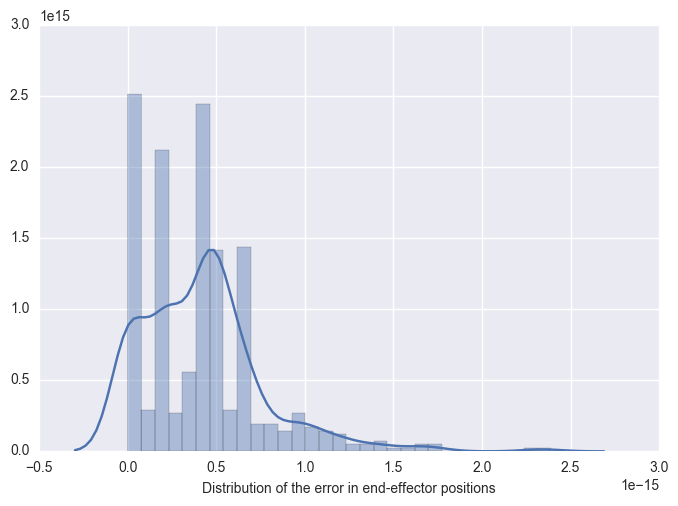

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
with open('kuka_arm/scripts/error_points.txt', 'r') as f:
    content = f.read().split(' ')
data = [float(l) for l in content if l != '\n' and l!= '']
plt.xlabel('Distribution of the error in end-effector positions', fontsize=10)
ax = sns.distplot(data);
plt.show()

## Project Build and Execution Instructions

Pre-requisites : Linux, ROS and Gazebo(7.7.0+) must be installed.

**Create the catkin workspace (if not already created)**
```
mkdir -p ~/catkin_ws/src
cd ~/catkin_ws/
catkin_make
```

**Clone the current repo**
```
cd ~/catkin_ws/src
git clone <repo_url>
```

**Install ROS project dependencies and set permissions***
```
cd ~/catkin_ws
rosdep install --from-paths src --ignore-src --rosdistro=kinetic -y
cd ~/catkin_ws/src/RoboND-Kinematics-Project/kuka_arm/scripts
sudo chmod +x target_spawn.py
sudo chmod +x IK_server.py
sudo chmod +x safe_spawner.sh
```

**Build the project**
```
cd ~/catkin_ws
catkin_make
```

**Add to .bashrc**
```
export GAZEBO_MODEL_PATH=~/catkin_ws/src/RoboND-Kinematics-Project/kuka_arm/models
source ~/catkin_ws/devel/setup.bash
```

**Configure demo mode**
Set proper demo flag "true"/"false" in inverse_kinematics.launch file under /RoboND-Kinematics-Project/kuka_arm/launch. When demo is true, the IK_Server code is not executed for the pick and place operations.

**Launch the simulation**
```
cd ~/catkin_ws/src/RoboND-Kinematics-Project/kuka_arm/scripts
./safe_spawner.sh
```

**Launch the IK Server (when not in demo mode)**
```
cd ~/catkin_ws/src/RoboND-Kinematics-Project/kuka_arm/scripts
./safe_spawner.sh
```

**Alternatively, to run only the FK part, launch only the following:**
```
roslaunch kuka_arm forward_kinematics.launch
```